In [1]:
# !git clone 'https://github.com/Lorenz92/SKADC1.git'
# % cd SKADC1
# !echo $PWD

In [2]:
import pandas as pd
import numpy as np

import src.dataset as dataset
import src.config as config 
from src.utils import *
import src.models as models
import src.losses as loss

path = config.TRAIN_PATCHES_FOLDER
%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [3]:
if 'google.colab' in str(get_ipython()):
  use_colab = True
  print('Running on CoLab')
else:
  use_colab = False
  print('Not running on CoLab')

Not running on CoLab


In [4]:
if use_colab:
    # Read file from Colab Notebook
    from google.colab import drive
    drive.mount('/content/drive')
    config.MODEL_WEIGHTS = "/content/drive/My Drive/Colab Notebooks/SKADC1"
    config.IMAGE_PATH = "/content/drive/My Drive/Colab Notebooks/SKADC1/asset/560Mhz_1000h.fits"

Dataset shape: (19222, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,1,1,1,19704.519,17712.942
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,1,1,1,18401.338,17160.919
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,1,1,1,16493.600,18506.577
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,2,1,1,18020.319,18182.095
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,1,1,1,18125.824,18600.680


Loading FITS file /Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/data/training/560Mhz_1000h.fits


100%|██████████| 19222/19222 [00:02<00:00, 6783.48it/s]


Initial dataset shape: (19222, 15)
Found 0 boxes with zero area
Rows to be deleted: 0
New dataset shape: (19222, 15)
Extending dataset with new computed columns...
Final cleaned dataset shape: (19222, 26)

Enlarging bboxes...
DONE - Enlarging bboxes...


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height,area_orig,area_cropped
0,24121695.0,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,17706.708393,19710.764566,17719.170105,6.264429,6.218255,5.734349,12.503792,12.461712,155.818657,155.818657
1,20167150.0,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,17112.270219,18509.603417,17209.564571,110.037236,44.503323,3.338082,216.538139,97.294352,21067.937901,21067.937901
2,20045120.0,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,18500.850356,16498.009965,18512.295208,5.738106,4.389739,4.827354,8.820318,11.444852,100.947234,100.947234
3,33938384.0,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18179.521298,18023.322729,18184.661968,3.031418,2.541842,6.050027,6.014593,5.140670,30.919039,30.919039
4,7527248.0,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18596.465498,18128.789688,18604.884928,4.236891,2.929772,4.869573,5.937378,8.419429,49.989332,49.989332



----------
Starting training image preprocessing...

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.0065856808796525
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...

Mean and stdev of the half-gaussian that best fits with noise distribution:
mu=4.561610766868865e-14, stdev=4.5037468510513567e-07
End of training image preprocessing.


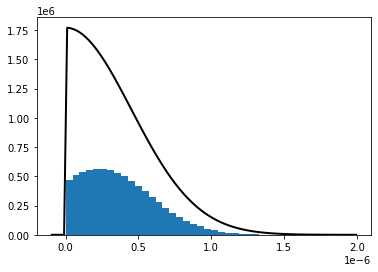

In [5]:
# Dataset parsing and loading
# use "subset" in config file to load a small portion of data for development/debugging purposes
ska_dataset = dataset.SKADataset(k=3, print_info=False, use_pb=False)

In [6]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig', 'area_cropped']].describe()

,width,height,area_orig,area_cropped
count,19222.000000,19222.000000,19222.000000,19222.000000
mean,6.282190,6.285123,44.731314,44.731314
std,3.122242,2.910949,169.529219,169.529219
min,4.964839,4.964839,24.649628,24.649628
25%,5.114121,5.116855,26.770928,26.770928
50%,5.388071,5.394034,29.928541,29.928541
75%,6.193903,6.206960,39.145862,39.145862
max,216.538139,97.294352,21067.937901,21067.937901


In [7]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig']].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.98,.99,1.])

,width,height,area_orig
0.10,5.021579,5.022318,25.628098
0.20,5.079478,5.083666,26.354817
0.30,5.153434,5.154979,27.221580
0.40,5.250224,5.256348,28.358833
0.50,5.388071,5.394034,29.928541
0.60,5.596149,5.603978,32.164977
0.70,5.931373,5.932616,36.070023
0.80,6.568193,6.603042,43.494231
0.90,8.241342,8.188366,63.754795
0.95,10.577456,10.646052,100.988437


In [8]:
ska_dataset.proc_train_df.head()

""


In [14]:
show_plot = False
ska_dataset.generate_patches(limit=30, plot_patches=show_plot)#, source_dir='./data/training/patches')

  0%|          | 0/5 [00:00<?, ?it/s]


Training image dimensions: 3498 x 3191
Cutting training image in patches of dim 20
hlim: 5
wlim: 5

 Generating patch 1/30
Patch 2_16396_16729_20 saved.

 Generating patch 2/30
Patch 3_16406_16729_20 saved.


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]


 Generating patch 3/30
Patch 161_16396_16739_20 saved.

 Generating patch 4/30
Patch 162_16406_16739_20 saved.


 60%|██████    | 3/5 [00:08<00:05,  2.85s/it]


 Generating patch 5/30
Patch 480_16406_16759_20 saved.


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]


 Generating patch 6/30
Patch 481_16416_16759_20 saved.

 Generating patch 7/30
Patch 638_16396_16769_20 saved.

 Generating patch 8/30
Patch 639_16406_16769_20 saved.


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


 Generating patch 9/30
Patch 640_16416_16769_20 saved.
Patches with no gt: 16
Total number of generated patches: 9

Class list: ['2_2' '2_3']
Number of distinct class labels: 2


In [16]:
ska_dataset.proc_train_df.head(30)

,index,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,...,x2s,y2s,class_label,patch_id,patch_name,patch_xo,patch_yo,patch_dim,bbox_w,bbox_h
0,0,13302538,-0.005224,-29.939449,-0.005224,-29.939449,0.000017,0.861438,0.076,0.076,...,16.453581,17.232278,2_2,2_16396_16729_20,560Mhz_1000h_16396_16729,16396,16729,20,4.967293,4.967293
1,1,8050427,-0.005032,-29.939239,-0.005032,-29.939239,0.000043,-0.000000,2.157,0.264,...,16.537825,19.000000,2_3,2_16396_16729_20,560Mhz_1000h_16396_16729,16396,16729,20,7.119101,7.426272
2,0,13302538,-0.005224,-29.939449,-0.005224,-29.939449,0.000017,0.861438,0.076,0.076,...,6.453581,17.232278,2_2,3_16406_16729_20,560Mhz_1000h_16406_16729,16406,16729,20,4.967293,4.967293
3,1,8050427,-0.005032,-29.939239,-0.005032,-29.939239,0.000043,-0.000000,2.157,0.264,...,6.537825,19.000000,2_3,3_16406_16729_20,560Mhz_1000h_16406_16729,16406,16729,20,6.537825,7.426272
4,0,13302538,-0.005224,-29.939449,-0.005224,-29.939449,0.000017,0.861438,0.076,0.076,...,16.453581,7.232278,2_2,161_16396_16739_20,560Mhz_1000h_16396_16739,16396,16739,20,4.967293,4.967293
5,1,8050427,-0.005032,-29.939239,-0.005032,-29.939239,0.000043,-0.000000,2.157,0.264,...,16.537825,10.423637,2_3,161_16396_16739_20,560Mhz_1000h_16396_16739,16396,16739,20,7.119101,8.849909
6,0,13302538,-0.005224,-29.939449,-0.005224,-29.939449,0.000017,0.861438,0.076,0.076,...,6.453581,7.232278,2_2,162_16406_16739_20,560Mhz_1000h_16406_16739,16406,16739,20,4.967293,4.967293
7,1,8050427,-0.005032,-29.939239,-0.005032,-29.939239,0.000043,-0.000000,2.157,0.264,...,6.537825,10.423637,2_3,162_16406_16739_20,560Mhz_1000h_16406_16739,16406,16739,20,6.537825,8.849909
8,0,7129791,-0.006576,-29.934639,-0.006576,-29.934639,0.000010,-0.000000,0.487,0.092,...,13.481423,16.048087,2_3,480_16406_16759_20,560Mhz_1000h_16406_16759,16406,16759,20,5.054642,5.281630
9,0,7129791,-0.006576,-29.934639,-0.006576,-29.934639,0.000010,-0.000000,0.487,0.092,...,3.481423,16.048087,2_3,481_16416_16759_20,560Mhz_1000h_16416_16759,16416,16759,20,3.481423,5.281630


In [ ]:
# ska_dataset.analyze_class_distribution()

In [ ]:
# ska_dataset.split_train_val_stratified(random_state=42, val_portion=0.2)

# print(len(ska_dataset.train_patch_list))
# print(len(ska_dataset.val_patch_list))


Train list consists of 7 patches
Val list consists of 2 patches


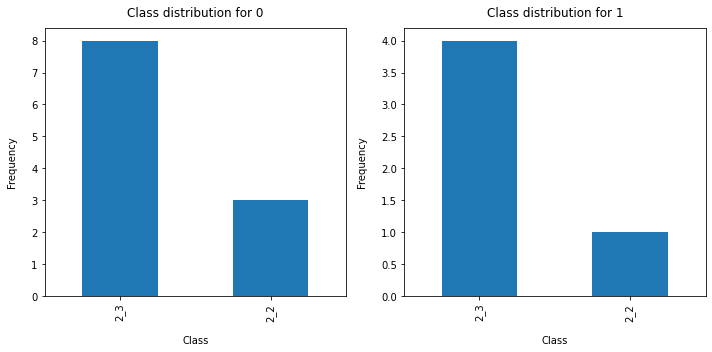

In [19]:
ska_dataset.split_train_val(random_state=42, val_portion=0.2)

## datagen + calc_rpn -> rpn_net -> rpn_to_roi -> calc_iou -> cls_net

# Training

In [ ]:
print_img(config.TRAIN_PATCHES_FOLDER, '3_16406_16729_20', show_data=True)


In [ ]:
# # Debugging

# train_patch_list = ska_dataset.train_patch_list
# patches_folder_path=config.TRAIN_PATCHES_FOLDER

# train_datagen = prep.get_anchor_gt(patches_folder_path, ['20_16396_16729_20'], backbone, pixel_mean=None)
# image, [y_rpn_cls_true, y_rpn_reg_true], img_data_aug, _, _, patch_id = next(train_datagen)



### Get FRCNN model

In [ ]:
# Choose the feature extraction model
backbone='baseline_16'
# backbone='vgg16'

if backbone=='baseline_16':
    config.resizePatch = True
    config.rpn_stride = 4
    config.num_rois = 128
    # config.anchor_box_scales = [16,32,64] # anchors in the original image size
    config.anchor_box_scales = [6, 8, 12, 16, 24, 32]
    config.resizeFinalDim = 100
    input_shape_1 = config.resizeFinalDim
else:
    config.resizePatch = True
    config.rpn_stride = 16
    config.num_rois = 4
    config.resizeFinalDim = 600
    input_shape_1=config.resizeFinalDim
    config.anchor_box_scales = [32, 64, 128]


config.anchor_num = len(config.anchor_box_ratios)*len(config.anchor_box_scales)
input_shape_2=(None, 4)

print(config.resizePatch)
print(config.rpn_stride)

checkpoint = get_model_last_checkpoint(backbone)
print(f'Model last checkpoint: {checkpoint}')

In [ ]:
rpn_model, detector_model, total_model = models.get_train_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model.summary()
detector_model.summary()
total_model.summary()

### Load weights

In [ ]:
models.load_weigths(rpn_model, detector_model, backbone, resume_train=False, checkpoint=checkpoint)
models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [ ]:
# Specifically checking backbone weights

# total_model.weights[24:25][0][0][0][0]

In [ ]:
# Check that all of the pretrained weights have been loaded.
import numpy as np
for i, j in zip(total_model.weights, rpn_model.weights): 
    # print(i,j)
    assert np.allclose(i,j), 'Weights don\'t match!'

### Train

- errore "Exception: 'a' cannot be empty unless no samples are taken" quando nel sampling ci sono meno di 4 roi
- errore "None type object is not iterable" dovuto al max(IoUs) quando calc_iou torna None, None, None, None
- patch di debug 1550_16376_16779_100
- capire il parametro classifier_regr_std in che modo influenza il training

- provare normalizzazione valori immagini di input
- provare a far passare più roi anzichè 4

In [ ]:
# zzz = np.load(f'{config.TRAIN_PATCHES_FOLDER}/3100_16376_16829_100/3100_16376_16829_100.npy')

# print_img(config.TRAIN_PATCHES_FOLDER, '3100_16376_16829_100')

20_16396_16729_20

In [ ]:
len(ska_dataset.train_patch_list)

In [ ]:
from src.train import *

val_patch_list = None
# train_frcnn(rpn_model, detector_model, total_model, ['3_16406_16729_20'], val_patch_list, ska_dataset.class_list, num_epochs=100, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone=backbone, resume_train=True)
train_frcnn(rpn_model, detector_model, total_model, ska_dataset.train_patch_list, val_patch_list, ska_dataset.class_list, num_epochs=500, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone=backbone, resume_train=False)

In [ ]:
total_model.save_weights(f'{config.MODEL_WEIGHTS}/{backbone}/0_frcnn_{backbone}.h5')

# Validation

In [ ]:
rpn_model_eval, detector_model_eval, total_model_eval = models.get_eval_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, input_shape_fmap=None, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model_eval.summary()
detector_model_eval.summary()
total_model_eval.summary()

In [ ]:
# Models used for mAP eval
cp = '13_frcnn_baseline_16.h5'
models.load_weigths(rpn_model_eval, detector_model_eval, backbone, checkpoint=cp)
models.compile_models(rpn_model_eval, detector_model_eval, total_model_eval, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [ ]:
patch_id = ['6240_16766_17119_20']
# patch_id = ska_dataset.train_patch_list
# print(patch_id)
# gt = pd.read_pickle(f'{config.TRAIN_PATCHES_FOLDER}/{patch_id[0]}/{patch_id[0]}.pkl')
# display(gt['class_label'])

preds, mAP, prec, recall = evaluate_model(rpn_model_eval, detector_model_eval, backbone, patch_id, ska_dataset.class_list, metric_threshold=.5)

In [ ]:
preds

In [ ]:
print(config.patch_dim , float(config.resizeFinalDim))

In [ ]:
print_img(config.TRAIN_PATCHES_FOLDER, '6240_16766_17119_20')

In [ ]:
anch = pd.read_pickle(f'{config.EVAL_RESULTS}/3_16406_16729_20/3_16406_16729_20.pkl')
display(anch)

In [ ]:
anch['width'] = anch['x2s'] - anch['x1s']
anch['heght'] = anch['y2s'] - anch['y1s']

In [ ]:
anch.describe() 

In [ ]:
print_img(config.TRAIN_PATCHES_FOLDER, '6240_16766_17119_20', config.EVAL_RESULTS)

TODO - 20210508:
- [X] troncamento rumore a 1e-6 tramite half gaussian

TODO - 20210605:
- [X] modificare RPNNet in modo che dia in output anche la backbone - Lorenzo
- [X] scrivere bene training loop: salvare le loss in un df su disco + salvare pesi modello ad ogni giro (Lorenzo - finire di debuggare)

TODO - 20210620:
- [x] implementare mAP in una funzione che prende come parametro un modello o i suoi pesi
- [x] implementare resNet50
- [x] implementare predicted rois - Lorenzo
- [X] implementare plot loss training - Lorenzo
- [X] finire classe datasetv2 - Alice
- [X] check se su colab le performance sono migliori - Lorenzo

TODO - 20210627
- [X] split dataset su combinazioni classi - Alice
- [x] provare campionamento random patch ed osservare le due distribuzioni - Alice

TODO - 20210703
- [x] sistemare salvataggio loss training loop - Lorenzo
- [x] Riscalare immagini tra 0-255 - Alice
- [x] capire se passare tre immagini diverse come input
- [x] usare media vgg16 per zero-centering - Alice

TODO - 20210705
- [x] sistemare nomi funzioni dataset per trasformazione rgb

TODO - 20210711
- [x] rifattorizzare classe dataset spostando nel costruttore i metodi che calcolano i suoi attributi - Lorenzo
- [x] chek valori pixel in input per resnet
- [x] fare funzione per plottare le predictions
- [ ] trainare tutto su colab

TODO - 20210714
- [x] ragionare su come scalare le immagini fra 0 e 1, attualmente hanno tanti valori schiacciati a 0 e il massimo su tutto il train a a 0.4

TODO - 20210717
- [ ] Ablation study: provare a rimuovere stage4 nella resnet - se c'è tempo
- [x] Provare con nostra pixel_mean e con vgg16 pixel_mean -> per il momento abbiamo scartato la prima opzione
- [ ] Fare qualche analisi di distribuzione delle classi/dim box del dataset - Alice
- [x] Aggiungere normalizzazione dopo zero centering per resNet50, sulla base del range globale dell'immagine di training
- [ ] Provare pulizia dataset originale sulla base del rumore/flusso - Alice
- [ ] Cambiare nomi di tutto - alla fine
- [x] implementare zero-centering su volare medio RGB delle nostre patch
- [x] Funzione che trova l'ultimo checkpoint in colab prima del load_weights - Lorenzo

TODO - 20210801
- [x] Debuggare training baseline 8 e 16 - L
- [ ] Finire prove pulizia dataseet noise variando k - A

1.  Summary
    - riassunto progetto
2.  Background
    - SoTA + teoria di base
3.  System Description
    - descrizione dei nostri modelli e dei loro componenti (moduli)
4.  Experimental setup and results
    - dataset pre processing
    - training environment
    - metrics
    - results
5.  Results and error analysis
6.  Discussion

# Plotting

In [ ]:
loss_history = np.load(f"./model/{backbone}/loss_history.npy")
print(loss_history.shape)

In [ ]:
loss_history

In [ ]:
plot_loss(loss_history[150:])